In [14]:
#pip install pyodbc
#pip install sqlalchemy
#pip install pandas
#pip install networkx

In [15]:
import pandas as pd
from sqlalchemy import create_engine

user = 'admin'
password = 'admin'
host = 'localhost\\SQLEXPRESS'
database = 'WideWorldImporters'

engine = create_engine(
    'mssql+pyodbc://'
    f'{user}:{password}@{host}/{database}?'  # username:pwd@server:port/database
    'TrustServerCertificate=yes&'
    'driver=ODBC+Driver+17+for+SQL+Server'
)

test = pd.read_sql("select * from INFORMATION_SCHEMA.TABLES", engine)
test.head(30)

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,WideWorldImporters,Warehouse,Colors,BASE TABLE
1,WideWorldImporters,Warehouse,Colors_Archive,BASE TABLE
2,WideWorldImporters,Sales,OrderLines,BASE TABLE
3,WideWorldImporters,Warehouse,PackageTypes,BASE TABLE
4,WideWorldImporters,Warehouse,PackageTypes_Archive,BASE TABLE
5,WideWorldImporters,Warehouse,StockGroups,BASE TABLE
6,WideWorldImporters,Warehouse,StockItemStockGroups,BASE TABLE
7,WideWorldImporters,Warehouse,StockGroups_Archive,BASE TABLE
8,WideWorldImporters,Application,StateProvinces,BASE TABLE
9,WideWorldImporters,Sales,CustomerTransactions,BASE TABLE


### Explanation of the SQL Query

The SQL query in the next cell retrieves information about columns in tables from the `sys.columns` and `sys.tables` system views in SQL Server. Here's a breakdown of what the query does:

1. **Select Columns**:
    - `table_id`: The unique identifier of the table.
    - `schema_name`: The name of the schema to which the table belongs.
    - `table_name`: The name of the table.
    - `column_name`: The name of the column.
    - `primary_key_name`: The name of the primary key column, if it exists.

2. **From Clause**:
    - The query starts by selecting columns from the `sys.columns` view, which contains information about all columns in the database.

3. **Outer Apply**:
    - The `outer apply` operator is used to join the `sys.columns` view with itself to find the primary key column for each table. If a column is an identity column, it is considered the primary key.

4. **Join Clause**:
    - The query joins the `sys.columns` view with the `sys.tables` view to get the table names and schema names.

The resulting dataset provides a comprehensive list of columns in the database, along with their associated tables, schemas, and primary key information.


In [16]:
tdeps = pd.read_sql(
    """
    SELECT [source] = baseTable.name
          ,[source_schema] = schema_name(baseTable.schema_id)
          ,[target] = refdTable.name
          ,[target_schema] = schema_name(refdTable.schema_id)
          ,[link] = baseTable.name + '.' + baseCol.name + '->' +  refdTable.name + '.' + refdCol.name
          ,[qry] = 'select link=''' + baseTable.name + '.' + baseCol.name + '->' +  refdTable.name + '.' + refdCol.name + ''',source=''' + baseTable.name + ''',source_count= (select count(1) from ' + schema_name(baseTable.schema_id) + '.' + baseTable.name + '), ' + 
                              'target=''' + refdTable.name + ''',target_count= (select count(1) from '+ schema_name(refdTable.schema_id) + '.' + refdTable.name + '), ' +
                              'fk_count= (select count(1) from ' + schema_name(baseTable.schema_id) + '.' + baseTable.name + ' where ' + baseCol.name + ' is not null)'
      FROM [sys].[foreign_key_columns] fkc
      outer apply (select * from sys.tables o where o.object_id = fkc.[parent_object_id]) baseTable
      outer apply (select * from sys.columns o where o.object_id = fkc.[parent_object_id] and o.column_id = fkc.parent_column_id) baseCol
      outer apply (select * from sys.tables o where o.object_id = fkc.[referenced_object_id]) refdTable
      outer apply (select * from sys.columns o where o.object_id = fkc.[referenced_object_id] and o.column_id = fkc.referenced_column_id) refdCol
    """,
    engine
)

tdeps.head()

,source,source_schema,target,target_schema,link,qry
0,StockItems,Warehouse,Colors,Warehouse,StockItems.ColorID->Colors.ColorID,select link='StockItems.ColorID->Colors.ColorI...
1,OrderLines,Sales,PackageTypes,Warehouse,OrderLines.PackageTypeID->PackageTypes.Package...,select link='OrderLines.PackageTypeID->Package...
2,InvoiceLines,Sales,PackageTypes,Warehouse,InvoiceLines.PackageTypeID->PackageTypes.Packa...,select link='InvoiceLines.PackageTypeID->Packa...
3,StockItems,Warehouse,PackageTypes,Warehouse,StockItems.UnitPackageID->PackageTypes.Package...,select link='StockItems.UnitPackageID->Package...
4,StockItems,Warehouse,PackageTypes,Warehouse,StockItems.OuterPackageID->PackageTypes.Packag...,select link='StockItems.OuterPackageID->Packag...


In [17]:
qry = ""
for i, r in tdeps.iterrows():
    qry += "\n" + r["qry"]
    if i < tdeps.index.size - 1:
        qry += "\n union all"

tdepstats = pd.read_sql(qry, engine)
tdepstats.head(5)

,link,source,source_count,target,target_count,fk_count
0,StockItems.ColorID->Colors.ColorID,StockItems,227,Colors,36,128
1,OrderLines.PackageTypeID->PackageTypes.Package...,OrderLines,231412,PackageTypes,14,231412
2,InvoiceLines.PackageTypeID->PackageTypes.Packa...,InvoiceLines,228265,PackageTypes,14,228265
3,StockItems.UnitPackageID->PackageTypes.Package...,StockItems,227,PackageTypes,14,227
4,StockItems.OuterPackageID->PackageTypes.Packag...,StockItems,227,PackageTypes,14,227


In [18]:
tdeps_wstats = pd.concat([tdeps, tdepstats], join="inner", axis=1)
tdeps_wstats.head(20)

,source,source_schema,target,target_schema,link,qry,link,source,source_count,target,target_count,fk_count
0,StockItems,Warehouse,Colors,Warehouse,StockItems.ColorID->Colors.ColorID,select link='StockItems.ColorID->Colors.ColorI...,StockItems.ColorID->Colors.ColorID,StockItems,227,Colors,36,128
1,OrderLines,Sales,PackageTypes,Warehouse,OrderLines.PackageTypeID->PackageTypes.Package...,select link='OrderLines.PackageTypeID->Package...,OrderLines.PackageTypeID->PackageTypes.Package...,OrderLines,231412,PackageTypes,14,231412
2,InvoiceLines,Sales,PackageTypes,Warehouse,InvoiceLines.PackageTypeID->PackageTypes.Packa...,select link='InvoiceLines.PackageTypeID->Packa...,InvoiceLines.PackageTypeID->PackageTypes.Packa...,InvoiceLines,228265,PackageTypes,14,228265
3,StockItems,Warehouse,PackageTypes,Warehouse,StockItems.UnitPackageID->PackageTypes.Package...,select link='StockItems.UnitPackageID->Package...,StockItems.UnitPackageID->PackageTypes.Package...,StockItems,227,PackageTypes,14,227
4,StockItems,Warehouse,PackageTypes,Warehouse,StockItems.OuterPackageID->PackageTypes.Packag...,select link='StockItems.OuterPackageID->Packag...,StockItems.OuterPackageID->PackageTypes.Packag...,StockItems,227,PackageTypes,14,227
5,PurchaseOrderLines,Purchasing,PackageTypes,Warehouse,PurchaseOrderLines.PackageTypeID->PackageTypes...,select link='PurchaseOrderLines.PackageTypeID-...,PurchaseOrderLines.PackageTypeID->PackageTypes...,PurchaseOrderLines,8367,PackageTypes,14,8367
6,StockItemStockGroups,Warehouse,StockGroups,Warehouse,StockItemStockGroups.StockGroupID->StockGroups...,select link='StockItemStockGroups.StockGroupID...,StockItemStockGroups.StockGroupID->StockGroups...,StockItemStockGroups,442,StockGroups,10,442
7,SpecialDeals,Sales,StockGroups,Warehouse,SpecialDeals.StockGroupID->StockGroups.StockGr...,select link='SpecialDeals.StockGroupID->StockG...,SpecialDeals.StockGroupID->StockGroups.StockGr...,SpecialDeals,2,StockGroups,10,2
8,Cities,Application,StateProvinces,Application,Cities.StateProvinceID->StateProvinces.StatePr...,select link='Cities.StateProvinceID->StateProv...,Cities.StateProvinceID->StateProvinces.StatePr...,Cities,37940,StateProvinces,53,37940
9,SystemParameters,Application,Cities,Application,SystemParameters.DeliveryCityID->Cities.CityID,select link='SystemParameters.DeliveryCityID->...,SystemParameters.DeliveryCityID->Cities.CityID,SystemParameters,1,Cities,37940,1


In [19]:
qry = """
    select 
    [table_id] = c1.object_id, 
    [schema_name] = schema_name(t.schema_id), 
    [table_name] = t.name,  
    [column_name] = c1.name, 
    [primary_key_name] = keycol.name 
    from sys.columns c1
    outer apply (
        select name from sys.columns c2 
        where c1.object_id = c2.object_id and c2.is_identity = 1
    ) keycol
    join sys.tables t on c1.object_id = t.object_id
"""

tcols = pd.read_sql(qry, engine)
tcols.head(20)

,table_id,schema_name,table_name,column_name,primary_key_name
0,2099048,Warehouse,Colors,ColorID,None
1,2099048,Warehouse,Colors,ColorName,None
2,2099048,Warehouse,Colors,LastEditedBy,None
3,2099048,Warehouse,Colors,ValidFrom,None
4,2099048,Warehouse,Colors,ValidTo,None
5,82099333,Warehouse,Colors_Archive,ColorID,None
6,82099333,Warehouse,Colors_Archive,ColorName,None
7,82099333,Warehouse,Colors_Archive,LastEditedBy,None
8,82099333,Warehouse,Colors_Archive,ValidFrom,None
9,82099333,Warehouse,Colors_Archive,ValidTo,None


In [20]:
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from networkx.algorithms import approximation
from networkx.algorithms import community

matplotlib.rcParams['figure.figsize'] = [20, 12]

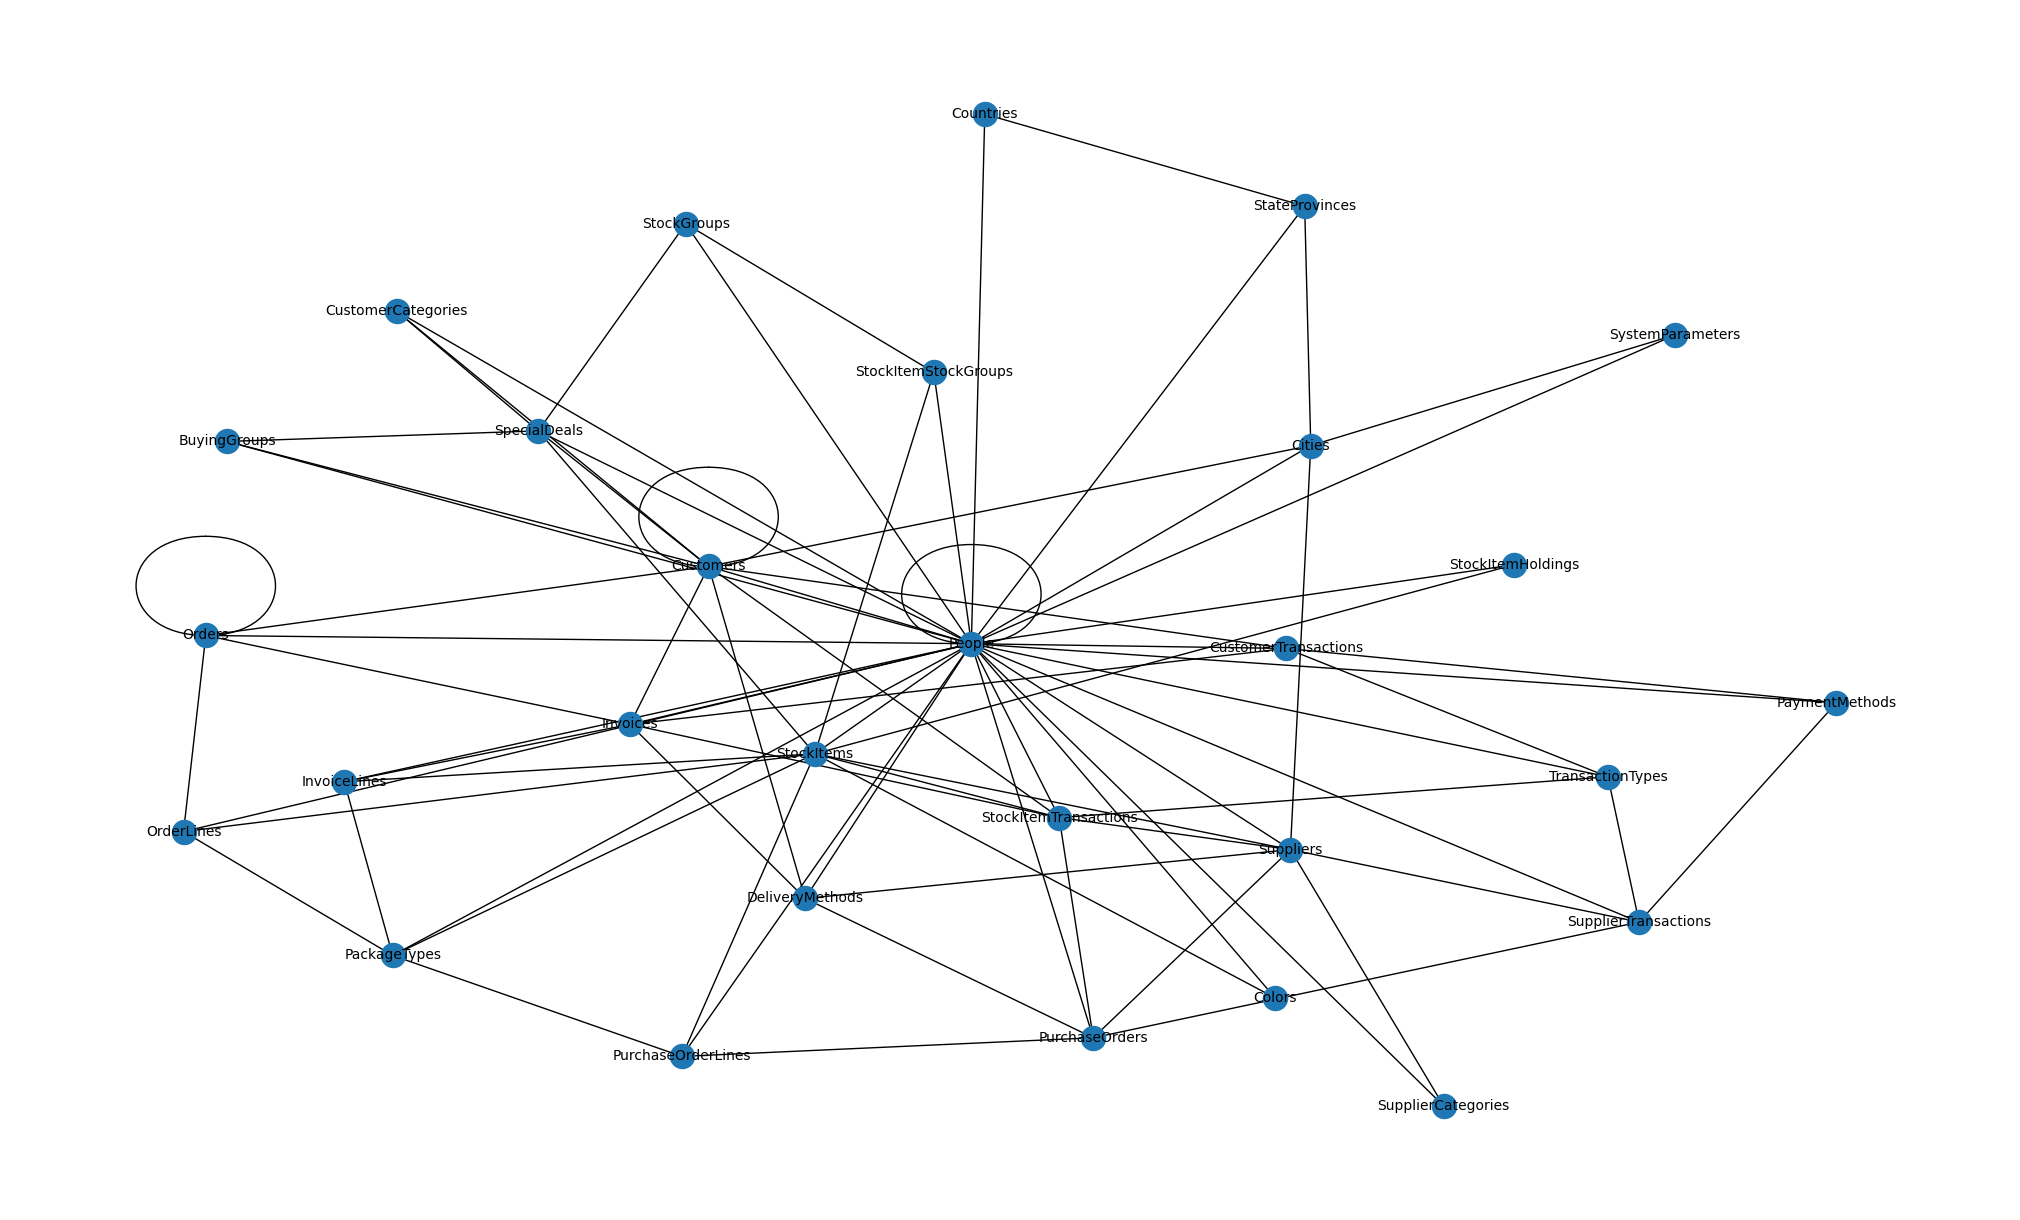

In [21]:
# Create a graph
G = nx.Graph()

# Create the graph from the dependencies
G = nx.from_pandas_edgelist(tdeps, source="source", target="target", create_using=G)

# Define the layout positions
pos = nx.spring_layout(G)

# Plot the graph
nx.draw(G, pos)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.show()

In [22]:
node_eigenvector = nx.eigenvector_centrality(G, max_iter=10000)
sorted((f"{c:0.3f}", v) for v, c in node_eigenvector.items())

[('0.080', 'Countries'),
 ('0.087', 'SystemParameters'),
 ('0.094', 'SupplierCategories'),
 ('0.096', 'StateProvinces'),
 ('0.098', 'Colors'),
 ('0.098', 'StockItemHoldings'),
 ('0.103', 'StockGroups'),
 ('0.105', 'PaymentMethods'),
 ('0.111', 'StockItemStockGroups'),
 ('0.124', 'BuyingGroups'),
 ('0.124', 'CustomerCategories'),
 ('0.131', 'TransactionTypes'),
 ('0.136', 'OrderLines'),
 ('0.138', 'PurchaseOrderLines'),
 ('0.141', 'InvoiceLines'),
 ('0.144', 'SupplierTransactions'),
 ('0.149', 'PackageTypes'),
 ('0.151', 'Cities'),
 ('0.156', 'CustomerTransactions'),
 ('0.164', 'Orders'),
 ('0.175', 'DeliveryMethods'),
 ('0.175', 'SpecialDeals'),
 ('0.176', 'PurchaseOrders'),
 ('0.206', 'Invoices'),
 ('0.214', 'Suppliers'),
 ('0.221', 'StockItemTransactions'),
 ('0.247', 'StockItems'),
 ('0.283', 'Customers'),
 ('0.567', 'People')]

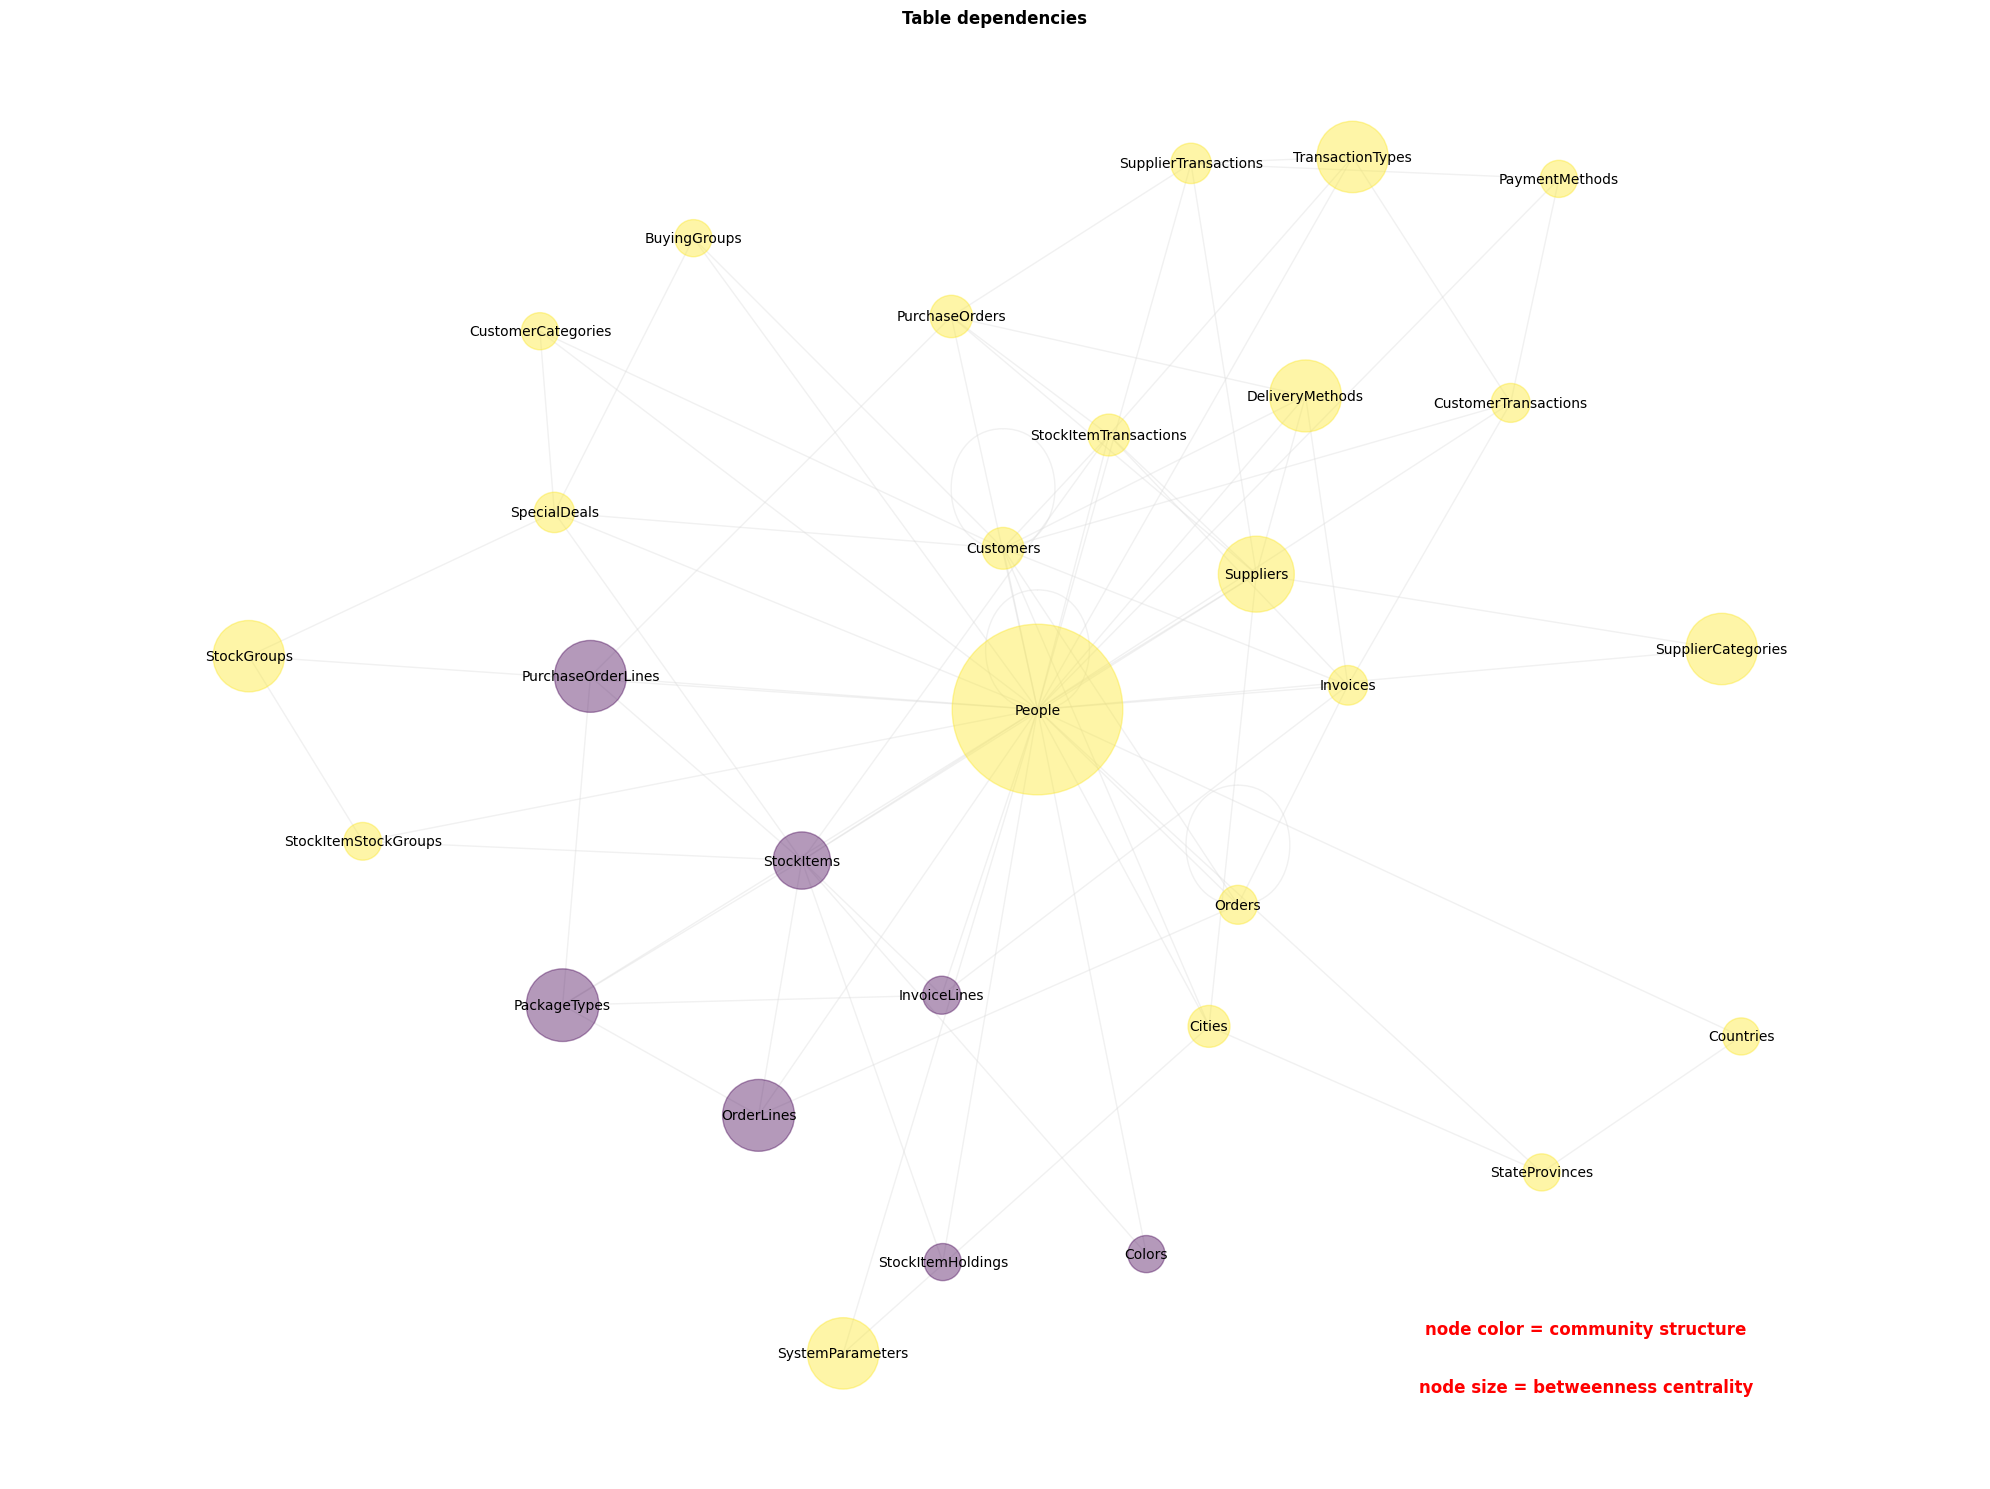

In [23]:
# Largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# Compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# Compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

# Draw graph
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)
nx.draw_networkx_labels(G, pos, font_size=10)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 12}
ax.set_title("Table dependencies", font)

# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "node color = community structure",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size = betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

```markdown
### Spectral Clustering on Graph `G`

In this section, we apply spectral clustering to the graph `G` to identify clusters within the graph. Spectral clustering is a technique that uses the eigenvalues of the adjacency matrix of the graph to perform clustering. The clusters are then added as labels to the nodes in the graph.

- **Graph `G`**: A NetworkX graph object representing the table dependencies.
- **Spectral Clustering**: Applied to the adjacency matrix of `G` to identify clusters.
- **Cluster Labels**: Added to the nodes in the graph.

The resulting cluster labels are printed to verify the clustering results.
```

In [24]:
from sklearn.cluster import spectral_clustering

# Apply spectral clustering
labels = spectral_clustering(nx.adjacency_matrix(G), n_clusters=4)

# Add the cluster labels to the nodes
for i, label in enumerate(labels):
    G.nodes[list(G.nodes)[i]]['cluster'] = label

# Print the cluster labels
print(labels)

[2 2 2 2 2 2 2 1 1 0 0 0 3 1 3 3 3 3 1 3 3 2 0 3 3 3 3 1 1]


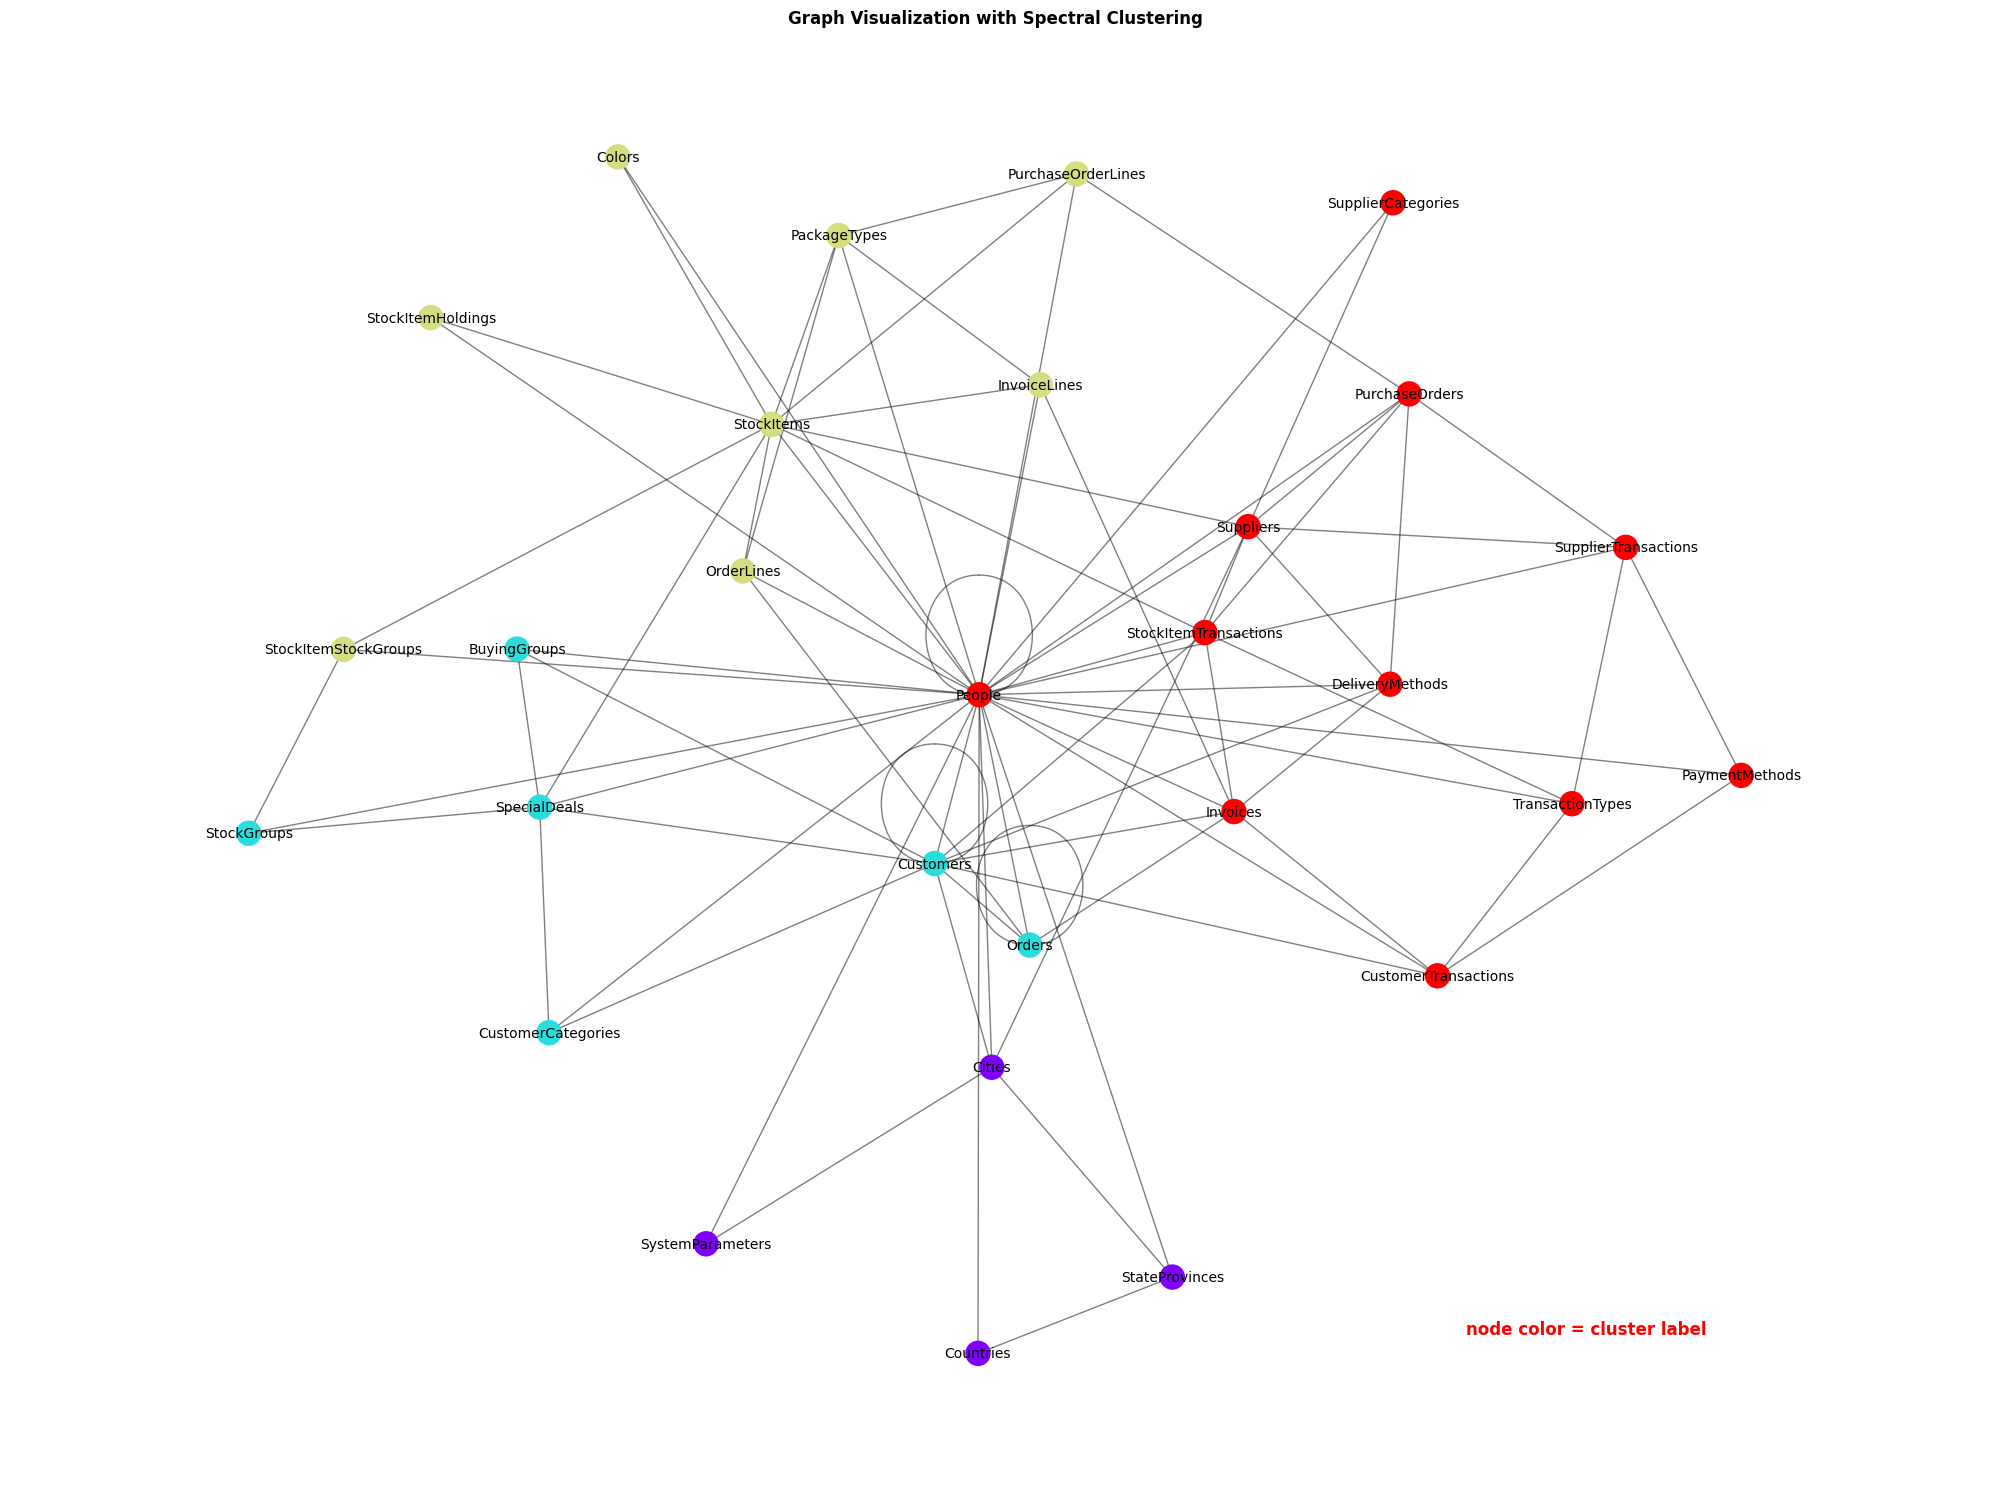

In [25]:
# Define the layout positions
pos = nx.spring_layout(G, seed=42)

# Draw the graph with nodes colored by cluster
fig, ax = plt.subplots(figsize=(20, 15))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color=labels, cmap=plt.cm.rainbow, node_size=300)
nx.draw_networkx_labels(G, pos, font_size=10)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 12}
ax.set_title("Graph Visualization with Spectral Clustering", font)

# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "node color = cluster label",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

```markdown
### Graph Visualization with Spectral Clustering

In this section, we visualize the graph `G` with nodes colored by their cluster labels obtained from spectral clustering. The layout positions are defined using the `spring_layout` function from NetworkX. The graph is drawn with nodes colored according to their cluster labels, and the title and legend are added for better understanding.

- **Graph `G`**: A NetworkX graph object representing the table dependencies.
- **Cluster Labels**: Obtained using spectral clustering, indicating the cluster each node belongs to.
- **Layout Positions**: Defined using `spring_layout` for better visualization.
- **Node Colors**: Represent different clusters.
- **Node Sizes**: Represent betweenness centrality values.

The visualization helps in understanding the structure and clustering of the graph, providing insights into the relationships between different tables in the database.
```

In [26]:
# Create dataframes for the clusters
def create_cluster_dataframe(G, cluster_labels):
    data = [{'cluster_label': cluster, 'node_label': node.split('.')[1] if '.' in node else node} for node, cluster in zip(G.nodes(), cluster_labels)]
    df = pd.DataFrame(data)
    return df

# Define the similarity calculation function
def calculate_similarity(schema_df, cluster_df):
    schema_set = set(schema_df['table_name'])
    matching = sum(1 for label in cluster_df['node_label'] if label in schema_set)
    total_schema = len(schema_df)
    total_cluster = len(cluster_df)
    return matching, total_schema, total_cluster

# Define the function to calculate best matches
def calculate_best_matches(subgraph_node_data, table_names_df):
    best_matches = {}
    best_similarity = {}
    match_ratio = {}

    unique_clusters = subgraph_node_data['cluster_label'].unique()
    for cluster in unique_clusters:
        cluster_df = subgraph_node_data[subgraph_node_data['cluster_label'] == cluster]
        best_similarity[cluster] = 0.0
        best_matches[cluster] = None

        unique_schemas = table_names_df['table_schema'].unique()

        for schema in unique_schemas:
            schema_df = table_names_df[table_names_df['table_schema'] == schema]
            matching, total_schema, total_cluster = calculate_similarity(schema_df, cluster_df)

            similarity_percentage = (matching / total_cluster) * 100

            if similarity_percentage > best_similarity[cluster]:
                best_similarity[cluster] = similarity_percentage
                best_matches[cluster] = schema

            match_ratio[(cluster, schema)] = f"{total_cluster}/{matching}"

    overall_average_similarity = 0
    for cluster, schema in best_matches.items():
        if schema is not None:
            print(f"Best match for cluster {cluster+1} is schema '{schema}' with similarity {best_similarity[cluster]:.2f}% ({match_ratio[(cluster, schema)]})")
            overall_average_similarity += best_similarity[cluster]
    print(f'Overall Average similarity: {(overall_average_similarity/len(best_matches.items())):.2f}%')

# Create cluster dataframe
df_clusters = create_cluster_dataframe(G, labels)

# Load the table names DataFrame
table_names_df = pd.read_csv(r"C:\\Python\\Python\\AAA_UNI\\MBD\\Project\\gitlab\\graph_analysis\\tables_and_schemas_wwi.csv")

# Apply the similarity calculation to the clustered graph
print("World Wide Importers Graph Clustering:")
calculate_best_matches(df_clusters, table_names_df)

World Wide Importers Graph Clustering:
Best match for cluster 3 is schema 'Warehouse' with similarity 62.50% (8/5)
Best match for cluster 2 is schema 'Sales' with similarity 83.33% (6/5)
Best match for cluster 1 is schema 'Application' with similarity 100.00% (4/4)
Best match for cluster 4 is schema 'Application' with similarity 36.36% (11/4)
Overall Average similarity: 70.55%
